# 🌾**CROP BUG/PEST DETECTION**🌾

### Crop Pest Detection using ResNet & EfficientNet

This notebook builds a deep learning-based image classification system to detect 12 classes of crop pests.  
It uses transfer learning with ResNet and EfficientNet architectures for robust and efficient model performance.  
Steps include data preprocessing, model training, evaluation, and visualization of predictions to support early pest detection.  


## 📝**Loading Dataset**

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vencerlanz09/agricultural-pests-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/agricultural-pests-image-dataset


## 📦 **Imports and Setup**

In [2]:
# --- 📦 Imports and Setup ---
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
from PIL import Image

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda:0


## ⚙️ **Configuration**

In [3]:
# --- ⚙️ Configuration ---

TRAIN_DIR = "/kaggle/input/agricultural-pests-image-dataset"

# Hyperparameters
NUM_EPOCHS_PHASE1 = 10
NUM_EPOCHS_PHASE2 = 40
TOTAL_NUM_EPOCHS = NUM_EPOCHS_PHASE1 + NUM_EPOCHS_PHASE2

BATCH_SIZE = 32
LEARNING_RATE_PHASE1 = 0.001
LEARNING_RATE_PHASE2 = 0.0001


## 🖼️ **Data Augmentation and Loading**

In [4]:
# --- 🖼️ Data Augmentation and Loading ---

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'display': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
}


## 📂 **Dataset Preparation**

In [5]:
# --- 📂 Dataset Preparation ---

full_dataset = datasets.ImageFolder(TRAIN_DIR)
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"Classes: {class_names}")

# Splitting dataset
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Re-apply transforms to subsets
train_dataset_transformed = datasets.ImageFolder(TRAIN_DIR, transform=data_transforms['train'])
val_dataset_transformed = datasets.ImageFolder(TRAIN_DIR, transform=data_transforms['val'])
test_dataset_transformed = datasets.ImageFolder(TRAIN_DIR, transform=data_transforms['test'])

train_dataset_final = torch.utils.data.Subset(train_dataset_transformed, train_dataset.indices)
val_dataset_final = torch.utils.data.Subset(val_dataset_transformed, val_dataset.indices)
test_dataset_final = torch.utils.data.Subset(test_dataset_transformed, test_dataset.indices)


Classes: ['ants', 'bees', 'beetle', 'catterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil']


## 📦 **DataLoaders**

In [6]:
# --- 📦 DataLoaders ---

train_loader = DataLoader(train_dataset_final, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()//2 or 1)
val_loader = DataLoader(val_dataset_final, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()//2 or 1)
test_loader = DataLoader(test_dataset_final, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()//2 or 1)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset_final), 'val': len(val_dataset_final), 'test': len(test_dataset_final)}

print(f"Train size: {dataset_sizes['train']}")
print(f"Validation size: {dataset_sizes['val']}")
print(f"Test size: {dataset_sizes['test']}")


Train size: 3845
Validation size: 824
Test size: 825


## 🧠 **Model Initialization**

In [7]:
# --- 🧠 Model Initialization ---

def initialize_model(model_name, num_classes, freeze_features=True, use_pretrained=True):
    model = None
    input_size = 224

    if model_name == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if use_pretrained else None)
        if freeze_features:
            for param in model.parameters():
                param.requires_grad = False
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1 if use_pretrained else None)
        if freeze_features:
            for param in model.parameters():
                param.requires_grad = False
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    else:
        raise ValueError(f"Model {model_name} not supported.")

    return model, input_size


## 🔁 **Training Function**

In [8]:
# --- 🔁 Training Function ---

def train_model(model, criterion, optimizer, scheduler, num_epochs, phase_name="Training"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print(f"\n--- {phase_name} ---")
    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        scheduler.step(epoch_loss)
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history


## 📊 **Evaluation Function**

In [9]:
# --- 📊 Evaluation Function ---

def evaluate_model(model, data_loader, phase='test'):
    model.eval()
    running_corrects = 0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = running_corrects.double() / len(data_loader.dataset)
    print(f'{phase} Accuracy: {accuracy:.4f}')
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {phase}')
    plt.show()

    return all_labels, all_probs, accuracy


## 📉 **Plotting Loss and Accuracy**

In [10]:
# --- 📉 Plotting Loss and Accuracy ---

def plot_training_history(history):
    epochs = len(history['train_loss'])
    
    plt.figure(figsize=(14, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), history['train_loss'], label='Train Loss')
    plt.plot(range(1, epochs+1), history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), history['train_acc'], label='Train Acc')
    plt.plot(range(1, epochs+1), history['val_acc'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


## 📈 **ROC Curve Plotting**

In [11]:
# --- 📈 ROC Curve Plotting ---

def plot_roc_curve(labels, probs, class_names):
    labels_bin = label_binarize(labels, classes=list(range(len(class_names))))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], np.array(probs)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Class')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


## 🧪 **Train the Model**

In [12]:
# --- 🧪 Train the Model ---

# Initialize and train
model_name = "resnet18"  # or "efficientnet_b0"
model, input_size = initialize_model(model_name, num_classes, freeze_features=True)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE_PHASE1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

# Phase 1: Train only classifier
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS_PHASE1, phase_name="Phase 1: Classifier Training")

# Phase 2: Fine-tune all layers
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE_PHASE2)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

model, history_finetune = train_model(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS_PHASE2, phase_name="Phase 2: Fine-tuning")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]



--- Phase 1: Classifier Training ---
Epoch 1/10
----------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train Loss: 1.7734 Acc: 0.4572
val Loss: 0.8826 Acc: 0.7767

Epoch 2/10
----------
train Loss: 1.2102 Acc: 0.6401
val Loss: 0.6428 Acc: 0.8155

Epoch 3/10
----------
train Loss: 1.0485 Acc: 0.6762
val Loss: 0.5696 Acc: 0.8398

Epoch 4/10
----------
train Loss: 0.9845 Acc: 0.6988
val Loss: 0.5358 Acc: 0.8289

Epoch 5/10
----------
train Loss: 0.9087 Acc: 0.7170
val Loss: 0.4721 Acc: 0.8519

Epoch 6/10
----------
train Loss: 0.9106 Acc: 0.7139
val Loss: 0.4484 Acc: 0.8544

Epoch 7/10
----------
train Loss: 0.8789 Acc: 0.7178
val Loss: 0.4329 Acc: 0.8580

Epoch 8/10
----------
train Loss: 0.8732 Acc: 0.7165
val Loss: 0.4171 Acc: 0.8629

Epoch 9/10
----------
train Loss: 0.8676 Acc: 0.7204
val Loss: 0.4085 Acc: 0.8714

Epoch 10/10
----------
train Loss: 0.8395 Acc: 0.7352
val Loss: 0.4207 Acc: 0.8653

Training complete in 3m 53s
Best val Acc: 0.8714

--- Phase 2: Fine-tuning ---
Epoch 1/40
----------
train Loss: 0.7930 Acc: 0.7384
val Loss: 0.3929 Acc: 0.8762

Epoch 2/40
----------
train L

## 📊 **Final Evaluation**

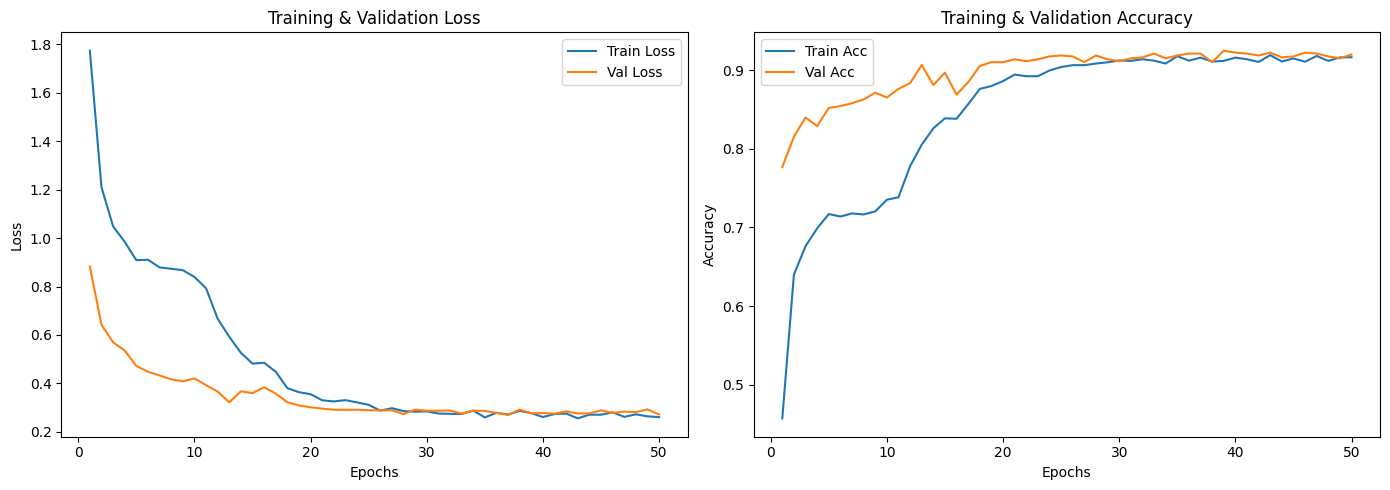

Test Accuracy: 0.9055

Classification Report:
              precision    recall  f1-score   support

        ants       0.90      0.97      0.93        66
        bees       0.94      0.95      0.95        82
      beetle       0.84      0.68      0.75        60
catterpillar       0.83      0.74      0.78        68
  earthworms       0.85      0.81      0.83        48
      earwig       0.88      0.88      0.88        64
 grasshopper       0.90      0.94      0.92        77
        moth       0.95      1.00      0.98        63
        slug       0.83      0.85      0.84        67
       snail       0.98      0.99      0.98        85
        wasp       0.93      0.97      0.95        71
      weevil       0.96      1.00      0.98        74

    accuracy                           0.91       825
   macro avg       0.90      0.90      0.90       825
weighted avg       0.90      0.91      0.90       825


Confusion Matrix:


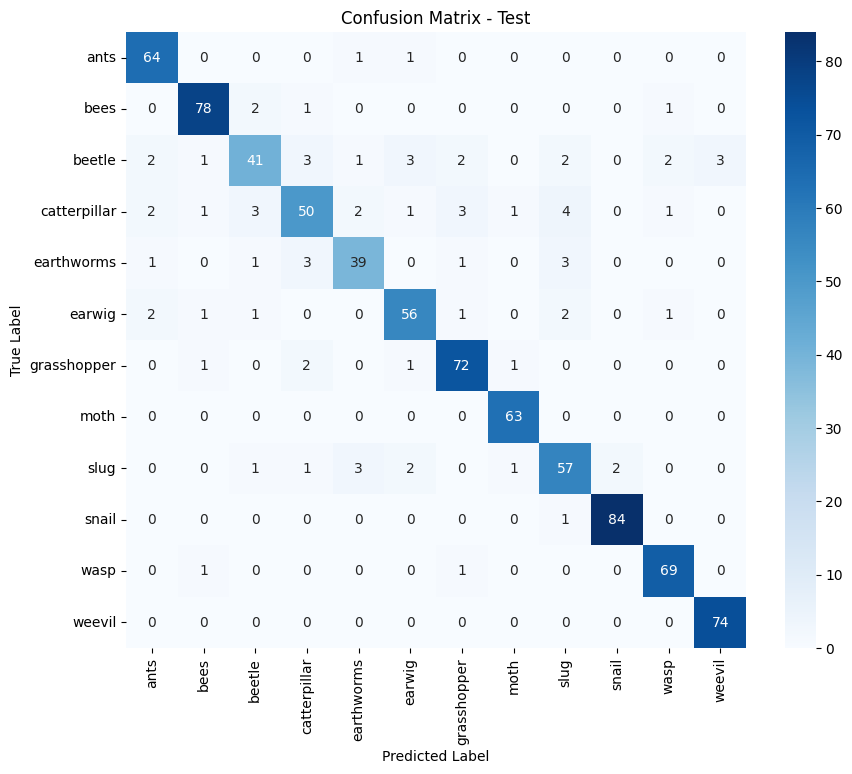

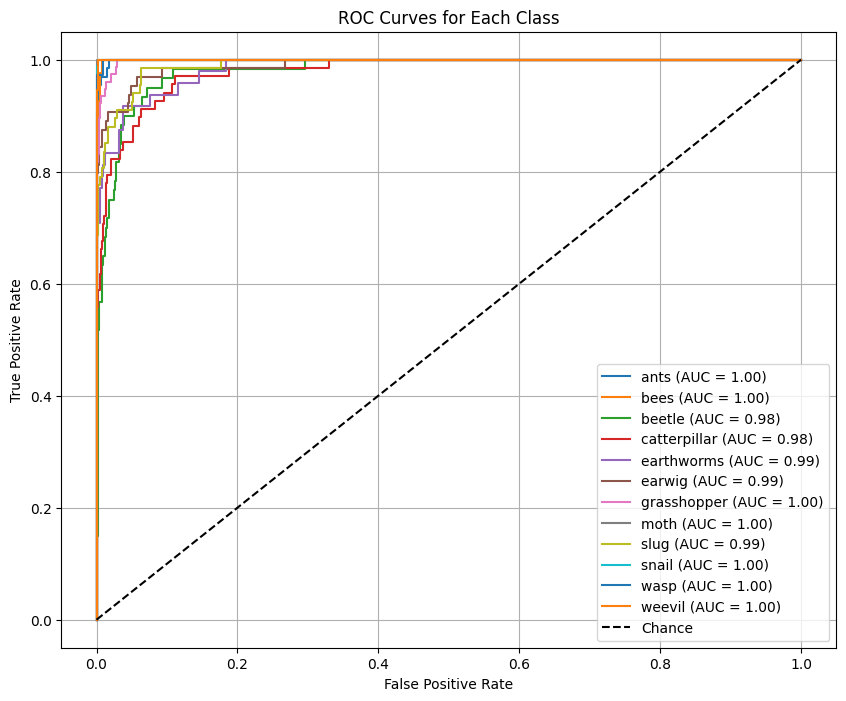

In [13]:
# --- 📊 Final Evaluation ---

plot_training_history({
    'train_loss': history['train_loss'] + history_finetune['train_loss'],
    'val_loss': history['val_loss'] + history_finetune['val_loss'],
    'train_acc': history['train_acc'] + history_finetune['train_acc'],
    'val_acc': history['val_acc'] + history_finetune['val_acc'],
})

all_labels, all_probs, test_accuracy = evaluate_model(model, dataloaders['test'], phase="Test")

plot_roc_curve(all_labels, all_probs, class_names)


## 💾 **Save the Trained Model**

In [14]:
# --- 💾 Save the Trained Model ---

torch.save(model.state_dict(), f"{model_name}_best_model.pth")
print("Model saved successfully!")


Model saved successfully!


## 🌐 **Export Model to ONNX**

In [15]:
# --- 🌐 Export Model to ONNX ---

dummy_input = torch.randn(1, 3, 224, 224, device=device)
onnx_filename = f"{model_name}_exported.onnx"

torch.onnx.export(
    model, 
    dummy_input, 
    onnx_filename, 
    input_names=["input"], 
    output_names=["output"], 
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}, 
    export_params=True, 
    opset_version=11
)

print(f"ONNX model saved as {onnx_filename}")


ONNX model saved as resnet18_exported.onnx
